In [2]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers, models

In [3]:
df =pd.read_csv("dataset_file_directory.csv")


In [4]:
p6_dataset =df[df['Participant']== 'P06']
p6_datasets =p6_dataset[~p6_dataset['Label'].isin([ 'dysregulated','affectionate','social'])]

In [5]:
classess=p6_datasets['Label'].value_counts()

In [6]:
classess

delighted     227
request       124
yes           123
selftalk       56
frustrated     30
Name: Label, dtype: int64

In [7]:
p6_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 3818 to 4386
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     560 non-null    object
 1   Participant  560 non-null    object
 2   Label        560 non-null    object
dtypes: object(3)
memory usage: 17.5+ KB


In [8]:
# Specify the directory where your Python script is located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
# Define the relative path to the WAV files directory
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

In [9]:
def extract_audio_features(dataset):
    null_file = 0
    
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None) 
                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                stft = librosa.stft(audio_data)
                fft_features = np.abs(stft)
                rmse = librosa.feature.rms(y=audio_data)
                
                fft_features_db = librosa.amplitude_to_db(fft_features, ref=np.max)

            # Calculate the mean of FFT features
                fft_features_mean = np.mean(fft_features_db, axis=1)
                rmse_mean = np.mean(rmse)
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
                
                # Combine the extracted features into a single vector
                combined_mmcs=np.hstack((mfccs_mean,mel_spectrogram_mean,chroma_mean,spectral_contrast_mean))
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, mel_spectrogram_mean, fft_features_mean, rmse_mean))
                mf_mel=np.hstack((mfccs_mean,mel_spectrogram_mean))
                mf_co=np.hstack((mfccs_mean,chroma_mean))
                mf_ch=np.hstack((mfccs_mean,spectral_contrast_mean))
                # Append the extracted features and label to the lists
                mf_ch_list.append(mf_mel)
                mf_co_list.append(mf_ch)
                mf_mel_list.append(mf_co)
                mfcc_fe.append(mfccs_mean)
                rmse_fe.append(rmse_mean)
                chroma_fe.append(chroma_mean)
                spectral_constrast_fe.append(spectral_contrast_mean)
                mel_spectrogram_fe.append(mel_spectrogram_mean)
                fft_fe.append(fft_features_mean)
                combined_4.append(combined_mmcs)
                combined_fe.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file += 1
            print(f"Audio file not found: {wav_file_path}")

    print("Related audio files not found count:", null_file)

    return null_file


In [10]:
mfcc_fe=[]
rmse_fe=[]
chroma_fe=[]
spectral_constrast_fe=[]
mel_spectrogram_fe=[]
fft_fe=[]

#fusion of mfcc+mel,fusion of mfcc + contrast,mfcc+chroma
mf_ch_list=[]
mf_co_list=[]
mf_mel_list=[]
combined_4=[]
labels_list=[]
combined_fe=[]
extract_audio_features(p6_datasets)


Related audio files not found count: 0


0

In [11]:
X_mfcc_fe  = np.array(mfcc_fe)
X_rmse_fe  = np.array(rmse_fe)
X_chroma_fe  = np.array(chroma_fe)
X_spectral_constrast_fe= np.array(spectral_constrast_fe)
X_mel_spectrogram_fe= np.array(mel_spectrogram_fe)
X_fft_fe= np.array(fft_fe)

X_mf_ch=np.array(mf_ch_list)
X_mf_co=np.array(mf_co_list)
X_mf_mel=np.array(mf_mel_list)
X_combined=np.array(combined_4)

y=np.array(labels_list)

In [12]:
X_mel_spectrogram_fe.shape

(560, 13)

In [13]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train_mfccs, X_test_mfccs, y_train1, y_test1 = train_test_split(X_mfcc_fe, y_encoded, test_size=0.2, random_state=42)
X_train_chroma, X_test_chroma, _, _ = train_test_split(X_chroma_fe, y_encoded, test_size=0.2, random_state=42)
X_train_spectral_contrast, X_test_spectral_contrast, _, _ = train_test_split(X_spectral_constrast_fe, y_encoded, test_size=0.2, random_state=42)
X_train_mel_spectrogram, X_test_mel_spectrogram, _, _ = train_test_split(X_mel_spectrogram_fe, y_encoded, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(X_fft_fe, y_encoded, test_size=0.2, random_state=42)
X_train_rmse, X_test_rmse, _, _ = train_test_split(X_rmse_fe, y_encoded, test_size=0.2, random_state=42)

X_mf_ch_train, X_mf_ch_test, _,_ = train_test_split(X_mf_ch, y_encoded, test_size=0.2, random_state=42)
X_mf_co_train, X_mf_co_test, _, _ = train_test_split(X_mf_co, y_encoded, test_size=0.2, random_state=42)
X_mf_mel_train, X_mf_mel_test, _, _ = train_test_split(X_mf_mel, y_encoded, test_size=0.2, random_state=42)
X_combined_train, X_combined_test, _, _ = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)



In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
def cnn_model(X_train,y_train,X_test,y_test):
    n_classes=p6_datasets['Label'].nunique()
    model = models.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    
        # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
        layers.Dense(n_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, 
                   validation_split=0.2, 
                    batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accuracy_stack.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")
    
    return model


def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape, )),  # Reshape for 1D convolution

        # Convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.Conv1D(256, 3, activation='relu', padding='same'),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



In [15]:
accuracy_stack=[]

In [16]:

cnn_model(X_train_mfccs,y_train1,X_test_mfccs,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 72ms/step - loss: 4.0926 - accuracy: 0.2821 - val_loss: 1.5840 - val_accuracy: 0.4444
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 1.9538 - accuracy: 0.2626 - val_loss: 1.4363 - val_accuracy: 0.4444
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 1.6031 - accuracy: 0.2961 - val_loss: 1.4562 - val_accuracy: 0.4333
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 1.4974 - accuracy: 0.3436 - val_loss: 1.4224 - val_accuracy: 0.4444
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 1.4511 - accuracy: 0.3659 - val_loss: 1.4049 - val_accuracy: 0.4556
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 1.4455 - accuracy: 0.4190 - val_loss: 1.3788 - val_accuracy: 0.4444
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 1.4577 - accuracy: 0.3603 - val_loss: 1.3842 - val_accuracy: 0.4444
Epoch 8/50
8/8 [===========

In [17]:
cnn_model(X_train_chroma,y_train1,X_test_chroma,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 56ms/step - loss: 1.5396 - accuracy: 0.3547 - val_loss: 1.3852 - val_accuracy: 0.4444
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 1.4207 - accuracy: 0.4134 - val_loss: 1.3632 - val_accuracy: 0.4444
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 1.4200 - accuracy: 0.4050 - val_loss: 1.3760 - val_accuracy: 0.4444
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 1.4209 - accuracy: 0.4134 - val_loss: 1.3659 - val_accuracy: 0.4444
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 1.4321 - accuracy: 0.4078 - val_loss: 1.3667 - val_accuracy: 0.4444
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 1.4257 - accuracy: 0.4162 - val_loss: 1.3728 - val_accuracy: 0.4444
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 1.4188 - accuracy: 0.3966 - val_loss: 1.3665 - val_accuracy: 0.4444
Epoch 8/50
8/8 [===========

In [18]:
cnn_model(X_train_mel_spectrogram,y_train1,X_test_mel_spectrogram,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 54ms/step - loss: 2.6295 - accuracy: 0.2682 - val_loss: 1.6614 - val_accuracy: 0.4444
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 1.9853 - accuracy: 0.2905 - val_loss: 1.6206 - val_accuracy: 0.3222
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 1.6593 - accuracy: 0.3520 - val_loss: 1.5595 - val_accuracy: 0.3000
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 1.5469 - accuracy: 0.3715 - val_loss: 1.5440 - val_accuracy: 0.3556
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 1.5404 - accuracy: 0.3883 - val_loss: 1.5241 - val_accuracy: 0.3667
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 1.4808 - accuracy: 0.3883 - val_loss: 1.5068 - val_accuracy: 0.3889
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 1.4562 - accuracy: 0.4022 - val_loss: 1.5105 - val_accuracy: 0.3667
Epoch 8/50
8/8 [===========

In [19]:

cnn_model(X_train_fft, y_train1, X_test_fft, y_test1)


Epoch 1/50
8/8 [==============================] - 2s 179ms/step - loss: 17.9758 - accuracy: 0.2626 - val_loss: 1.4530 - val_accuracy: 0.4444
Epoch 2/50
8/8 [==============================] - 1s 148ms/step - loss: 1.6382 - accuracy: 0.3464 - val_loss: 1.4638 - val_accuracy: 0.4444
Epoch 3/50
8/8 [==============================] - 1s 152ms/step - loss: 1.5155 - accuracy: 0.3464 - val_loss: 1.3839 - val_accuracy: 0.4444
Epoch 4/50
8/8 [==============================] - 1s 147ms/step - loss: 1.4910 - accuracy: 0.3520 - val_loss: 1.3954 - val_accuracy: 0.4444
Epoch 5/50
8/8 [==============================] - 1s 136ms/step - loss: 1.4990 - accuracy: 0.3520 - val_loss: 1.3921 - val_accuracy: 0.4444
Epoch 6/50
8/8 [==============================] - 1s 134ms/step - loss: 1.4829 - accuracy: 0.3771 - val_loss: 1.3769 - val_accuracy: 0.4444
Epoch 7/50
8/8 [==============================] - 1s 132ms/step - loss: 1.5436 - accuracy: 0.3715 - val_loss: 1.4419 - val_accuracy: 0.4444
Epoch 8/50
8/8 [===

In [20]:
X_train_rmse.shape


(448,)

In [24]:

model2=create_cnn_model(1,5)
history = model2.fit(X_train_rmse, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model2.evaluate(X_test_rmse, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
8/8 [==============================] - 1s 57ms/step - loss: 1.5921 - accuracy: 0.3687 - val_loss: 1.5575 - val_accuracy: 0.4444
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 1.5205 - accuracy: 0.4134 - val_loss: 1.4320 - val_accuracy: 0.4444
Epoch 3/10
8/8 [==============================] - 0s 12ms/step - loss: 1.4397 - accuracy: 0.4106 - val_loss: 1.3901 - val_accuracy: 0.4444
Epoch 4/10
8/8 [==============================] - 0s 12ms/step - loss: 1.4396 - accuracy: 0.4078 - val_loss: 1.3840 - val_accuracy: 0.4444
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: 1.4406 - accuracy: 0.4078 - val_loss: 1.3889 - val_accuracy: 0.4444
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 1.4182 - accuracy: 0.4106 - val_loss: 1.3895 - val_accuracy: 0.4444
Epoch 7/10
8/8 [==============================] - 0s 12ms/step - loss: 1.4108 - accuracy: 0.4106 - val_loss: 1.3796 - val_accuracy: 0.4444
Epoch 8/10
8/8 [===========

In [25]:


model1=create_cnn_model(7,5)
history = model1.fit(X_train_spectral_contrast, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model1.evaluate(X_test_spectral_contrast, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
8/8 [==============================] - 1s 59ms/step - loss: 2.0686 - accuracy: 0.2989 - val_loss: 1.4352 - val_accuracy: 0.4444
Epoch 2/10
8/8 [==============================] - 0s 16ms/step - loss: 1.5192 - accuracy: 0.3547 - val_loss: 1.4148 - val_accuracy: 0.4444
Epoch 3/10
8/8 [==============================] - 0s 17ms/step - loss: 1.4483 - accuracy: 0.3911 - val_loss: 1.3825 - val_accuracy: 0.4444
Epoch 4/10
8/8 [==============================] - 0s 15ms/step - loss: 1.4565 - accuracy: 0.3659 - val_loss: 1.4108 - val_accuracy: 0.4444
Epoch 5/10
8/8 [==============================] - 0s 17ms/step - loss: 1.4568 - accuracy: 0.3771 - val_loss: 1.4080 - val_accuracy: 0.3778
Epoch 6/10
8/8 [==============================] - 0s 18ms/step - loss: 1.4235 - accuracy: 0.3939 - val_loss: 1.3558 - val_accuracy: 0.4444
Epoch 7/10
8/8 [==============================] - 0s 15ms/step - loss: 1.4029 - accuracy: 0.4022 - val_loss: 1.3733 - val_accuracy: 0.4222
Epoch 8/10
8/8 [===========

In [26]:
cnn_model(X_mf_ch_train,y_train1,X_mf_ch_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 66ms/step - loss: 5.6675 - accuracy: 0.2765 - val_loss: 1.5805 - val_accuracy: 0.4111
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 2.0427 - accuracy: 0.3073 - val_loss: 1.4334 - val_accuracy: 0.4111
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 1.5803 - accuracy: 0.3436 - val_loss: 1.4760 - val_accuracy: 0.3778
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 1.4785 - accuracy: 0.3520 - val_loss: 1.4234 - val_accuracy: 0.4000
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 1.4873 - accuracy: 0.3994 - val_loss: 1.4354 - val_accuracy: 0.3667
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 1.4395 - accuracy: 0.3994 - val_loss: 1.3911 - val_accuracy: 0.4444
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 1.4412 - accuracy: 0.4078 - val_loss: 1.4240 - val_accuracy: 0.4222
Epoch 8/50
8/8 [===========

In [27]:
cnn_model(X_mf_co_train,y_train1,X_mf_co_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 65ms/step - loss: 3.7747 - accuracy: 0.3101 - val_loss: 1.3856 - val_accuracy: 0.4000
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 1.7157 - accuracy: 0.3017 - val_loss: 1.4264 - val_accuracy: 0.4333
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 1.5404 - accuracy: 0.2905 - val_loss: 1.4036 - val_accuracy: 0.4444
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 1.5024 - accuracy: 0.3380 - val_loss: 1.3890 - val_accuracy: 0.4444
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 1.4453 - accuracy: 0.3436 - val_loss: 1.3905 - val_accuracy: 0.4444
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 1.4379 - accuracy: 0.3799 - val_loss: 1.3893 - val_accuracy: 0.4444
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 1.4412 - accuracy: 0.3883 - val_loss: 1.4066 - val_accuracy: 0.4333
Epoch 8/50
8/8 [===========

In [28]:
cnn_model(X_mf_mel_train,y_train1,X_mf_mel_test,y_test1)

Epoch 1/50
8/8 [==============================] - 3s 115ms/step - loss: 4.8052 - accuracy: 0.2654 - val_loss: 1.4434 - val_accuracy: 0.4444
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 1.8850 - accuracy: 0.2989 - val_loss: 1.4018 - val_accuracy: 0.4444
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 1.5445 - accuracy: 0.3408 - val_loss: 1.4089 - val_accuracy: 0.4444
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 1.5215 - accuracy: 0.3575 - val_loss: 1.4166 - val_accuracy: 0.4444
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 1.4685 - accuracy: 0.3771 - val_loss: 1.4033 - val_accuracy: 0.4444
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 1.4047 - accuracy: 0.3911 - val_loss: 1.3831 - val_accuracy: 0.4444
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 1.4601 - accuracy: 0.3966 - val_loss: 1.3975 - val_accuracy: 0.4444
Epoch 8/50
8/8 [==========

In [29]:
cnn_model(X_combined_train,y_train1,X_combined_test,y_test1)

Epoch 1/50
8/8 [==============================] - 2s 72ms/step - loss: 4.8946 - accuracy: 0.3268 - val_loss: 1.7874 - val_accuracy: 0.3333
Epoch 2/50
8/8 [==============================] - 0s 28ms/step - loss: 1.9951 - accuracy: 0.3240 - val_loss: 1.4732 - val_accuracy: 0.3778
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 1.5606 - accuracy: 0.3799 - val_loss: 1.4221 - val_accuracy: 0.4000
Epoch 4/50
8/8 [==============================] - 0s 24ms/step - loss: 1.4001 - accuracy: 0.4385 - val_loss: 1.3889 - val_accuracy: 0.3889
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 1.4968 - accuracy: 0.3715 - val_loss: 1.4485 - val_accuracy: 0.3778
Epoch 6/50
8/8 [==============================] - 0s 25ms/step - loss: 1.4194 - accuracy: 0.3911 - val_loss: 1.4056 - val_accuracy: 0.4000
Epoch 7/50
8/8 [==============================] - 0s 23ms/step - loss: 1.4911 - accuracy: 0.3855 - val_loss: 1.3834 - val_accuracy: 0.4111
Epoch 8/50
8/8 [===========

In [30]:
accuracy_stack

[0.3482142984867096,
 0.375,
 0.375,
 0.3482142984867096,
 0.3482142984867096,
 0.3928571343421936,
 0.375,
 0.3392857015132904,
 0.2857142984867096,
 0.3303571343421936]

In [31]:
labels=p6_datasets['Label'].unique()

In [32]:
labels

array(['frustrated', 'selftalk', 'request', 'yes', 'delighted'],
      dtype=object)

In [33]:
import time
import matplotlib.pyplot as plt
# Define a function to train and evaluate a CNN model
def train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=10):
    start_time = time.time()

    model = create_cnn_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    end_time = time.time()

    return model, history, test_accuracy, end_time - start_time

# List of models and their input shapes
models_to_evaluate = [
    (X_train_mfccs, y_train1, X_test_mfccs, y_test1, X_train_mfccs.shape[1], len(set(labels))),
    (X_train_chroma, y_train1, X_test_chroma, y_test1, X_train_chroma.shape[1], len(set(labels))),
    (X_train_mel_spectrogram, y_train1, X_test_mel_spectrogram, y_test1, X_train_mel_spectrogram.shape[1], len(set(labels))),
    (X_train_fft, y_train1, X_test_fft, y_test1, X_train_fft.shape[1], len(set(labels))),
    (X_train_rmse, y_train1, X_test_rmse, y_test1, 1, len(set(labels))),
    (X_train_spectral_contrast, y_train1, X_test_spectral_contrast, y_test1,7, len(set(labels))),
    (X_mf_ch_train, y_train1, X_mf_ch_test, y_test1, X_mf_ch_train.shape[1], len(set(labels))),
    (X_mf_co_train, y_train1, X_mf_co_test, y_test1, X_mf_co_train.shape[1], len(set(labels))),
    (X_mf_mel_train, y_train1, X_mf_mel_test, y_test1, X_mf_mel_train.shape[1], len(set(labels))),
    (X_combined_train, y_train1, X_combined_test, y_test1, X_combined_train.shape[1], len(set(labels)))
]

# Train and evaluate models, and collect their accuracies and execution times
model_accuracies = []
execution_times = []

for X_train, y_train, X_test, y_test, input_shape, num_classes in models_to_evaluate:
    model, _, test_accuracy, execution_time = train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes)
    model_accuracies.append(test_accuracy)
    execution_times.append(execution_time)



Epoch 1/10
8/8 [==============================] - 1s 81ms/step - loss: 4.3687 - accuracy: 0.2514 - val_loss: 1.5513 - val_accuracy: 0.2333
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 1.6849 - accuracy: 0.2654 - val_loss: 1.3812 - val_accuracy: 0.4444
Epoch 3/10
8/8 [==============================] - 0s 39ms/step - loss: 1.5013 - accuracy: 0.3464 - val_loss: 1.4289 - val_accuracy: 0.4556
Epoch 4/10
8/8 [==============================] - 0s 38ms/step - loss: 1.4468 - accuracy: 0.3939 - val_loss: 1.3673 - val_accuracy: 0.4444
Epoch 5/10
8/8 [==============================] - 0s 36ms/step - loss: 1.4259 - accuracy: 0.3771 - val_loss: 1.3756 - val_accuracy: 0.4556
Epoch 6/10
8/8 [==============================] - 0s 38ms/step - loss: 1.4455 - accuracy: 0.3994 - val_loss: 1.3719 - val_accuracy: 0.4556
Epoch 7/10
8/8 [==============================] - 0s 36ms/step - loss: 1.4039 - accuracy: 0.4022 - val_loss: 1.3671 - val_accuracy: 0.4444
Epoch 8/10
8/8 [===========

Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 1.4239 - accuracy: 0.3799 - val_loss: 1.3746 - val_accuracy: 0.4444
Epoch 8/10
8/8 [==============================] - 0s 17ms/step - loss: 1.4055 - accuracy: 0.4022 - val_loss: 1.3409 - val_accuracy: 0.4444
Epoch 9/10
8/8 [==============================] - 0s 17ms/step - loss: 1.4237 - accuracy: 0.3939 - val_loss: 1.3578 - val_accuracy: 0.4444
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 1.4590 - accuracy: 0.3571
Epoch 1/10
8/8 [==============================] - 1s 86ms/step - loss: 5.1849 - accuracy: 0.3352 - val_loss: 1.5677 - val_accuracy: 0.3000
Epoch 2/10
8/8 [==============================] - 0s 45ms/step - loss: 1.6854 - accuracy: 0.3184 - val_loss: 1.4461 - val_accuracy: 0.4444
Epoch 3/10
8/8 [==============================] - 0s 43ms/step - loss: 1.5130 - accuracy: 0.3464 - val_loss: 1.4144 - val_accuracy: 0.4444
Epoch 4/10
8/8 [==============================] - 0s 45ms/step - loss

In [34]:
print(model_accuracies)
print(" ")
print(accuracy_stack)

[0.375, 0.3482142984867096, 0.4196428656578064, 0.3482142984867096, 0.3482142984867096, 0.3571428656578064, 0.4107142984867096, 0.3303571343421936, 0.3660714328289032, 0.4107142984867096]
 
[0.3482142984867096, 0.375, 0.375, 0.3482142984867096, 0.3482142984867096, 0.3928571343421936, 0.375, 0.3392857015132904, 0.2857142984867096, 0.3303571343421936]


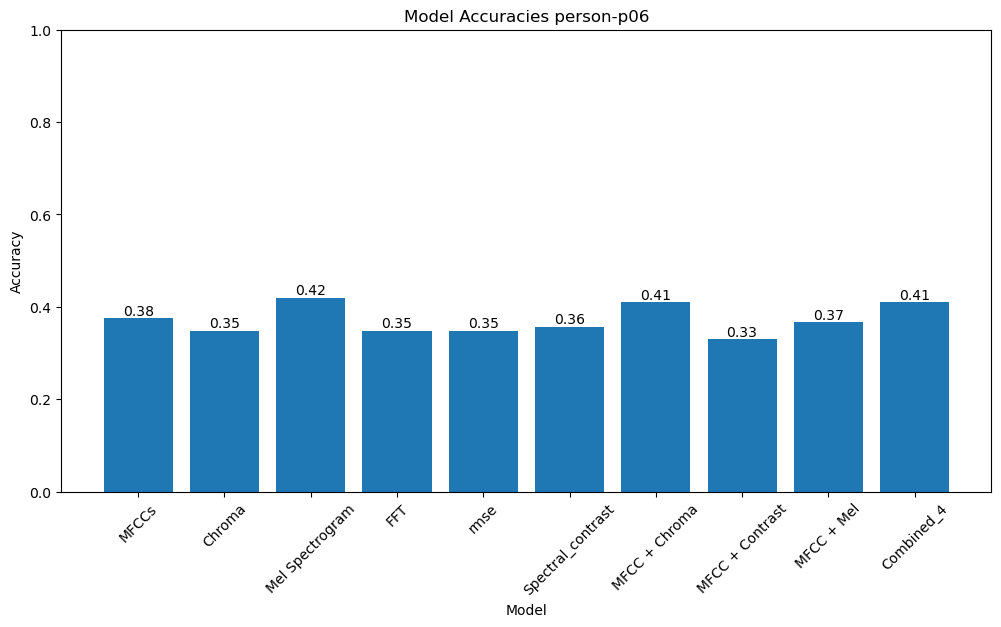

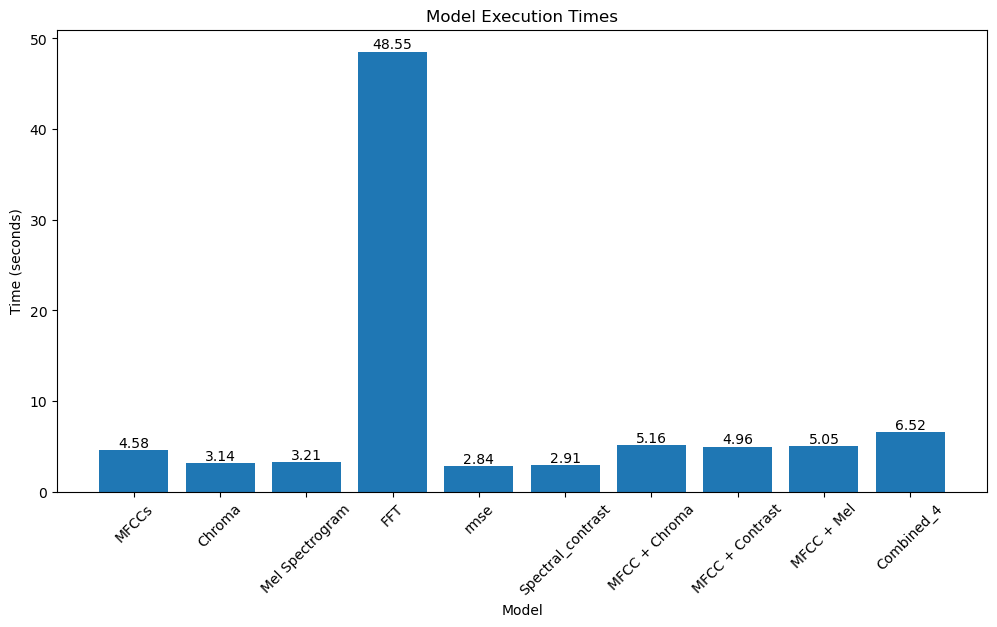

In [35]:

# Plot model accuracies
model_names = [
    "MFCCs", "Chroma", "Mel Spectrogram", "FFT","rmse","Spectral_contrast",
    "MFCC + Chroma", "MFCC + Contrast", "MFCC + Mel","Combined_4"
]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, model_accuracies)
plt.title("Model Accuracies person-p06")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate each bar with its accuracy value
for bar, accuracy in zip(bars, model_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()
# Plot execution times
plt.figure(figsize=(12, 6))
bar1=plt.bar(model_names, execution_times)
plt.title("Model Execution Times")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
for bar1, time in zip(bar1, execution_times):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{time:.2f}', ha='center', va='bottom')

plt.show()
